In [1]:
import numpy as np
from math import pi
from matplotlib import pyplot
from ipywidgets import interact

In [10]:
def hopp_vec(Mx,My,vec,px,py,deform=False):
    # generates hoping matrix on square lattice
    # vec= hopping vector
    # py=1 PBC along y otherwise OBC
    # px=1 PBC along x otherwise OBC
    
    hopin=np.zeros(shape=(Mx*My,Mx*My),dtype=complex)
    for i_y in range(My):
        for i_x in range(Mx):
            i_px=i_x+vec[0]
            i_py=i_y+vec[1]
            if ((i_px>=Mx or i_px<0) and i_py< My and i_py>=0):
                if i_px>=Mx :
                    hx=px
                else:
                    hx=px.conjugate()
                i_px=i_px%Mx
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hx
            elif ((i_py>=My or i_py<0) and i_px< Mx and i_px>=0):
                if i_py>=My :
                    hy=py
                else:
                    hy=py.conjugate()
                    
                i_py=i_py%My
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hy
                    
            elif (i_px>=Mx or i_px<0) and (i_py>=My or i_py<0):
                if i_px>=Mx:
                    hx=px
                else:
                    hx=px.conjugate()
    
                if i_py>=My:
                    hy=py
                else:
                    hy=py.conjugate()
                i_px=i_px%Mx
                i_py=i_py%My
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hx*hy
                
            elif i_px>=0 and i_px<Mx and i_py>=0 and i_py<My :
                if deform:
                    if vec[0]:
                        hopin[i_px+i_py*Mx,i_x+i_y*Mx]=2* np.sin(pi*(i_x+1/2)/Mx)**2
                    elif vec[1]:
                        hopin[i_px+i_py*Mx,i_x+i_y*Mx]=2* np.sin(pi*(i_y+1/2)/My)**2                     
                    else:
                        error('This is not a hopping!')
                else:
                    hopin[i_px+i_py*Mx,i_x+i_y*Mx]=1
                    
    return hopin


def vNent_contour(GA,epsilon=1e-9):
    chi0, evec0 =np.linalg.eigh(GA)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    evec1=evec0[:,i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    chi2=chi1[i1]
    evec2=evec1[:,i1]
    DvN=-((1-chi2)*np.log(1-chi2)+chi2*np.log(chi2))
    f1=np.dot((np.abs(evec2)**2),np.diag(DvN))
    return np.sum(f1,axis=1) 

In [15]:
# static case: ground state of deformed hopping Hamiltonian
Lx=32
Ly=100
N=Lx*Ly
Lsub=int(N/2)
Npt=int(N/2)
px=1
py=0

H1_hop=hopp_vec(Lx,Ly,[0,1],px,py,deform=True)+hopp_vec(Lx,Ly,[1,0],px,py,deform=True)
H1=(H1_hop+H1_hop.T)/2
print("Hamiltonian is constructed")
E1,V1=np.linalg.eigh(H1)
print("Eigenstates are found")
GA=np.dot(V1[:Lsub,:Npt],V1[:Lsub,:Npt].T)
entcont1=vNent_contour(GA)
vN_mat=np.reshape(entcont1,[int(Ly/2),Lx])
print("Ent contour is computed")

Hamiltonian is constructed
Eigenstates are found
Ent contour is computed


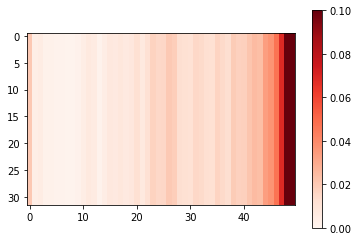

In [14]:
f1=pyplot.figure()
pos=pyplot.imshow(np.real(vN_mat).T, cmap='Reds', vmin=0, vmax=0.1,
                             interpolation='none')
f1.colorbar(pos)
pyplot.show()


In [21]:
# Dyanmic case: quench from uniform to deformed model
Lx=10
Ly=400
N=Lx*Ly
Lsub=int(N/2)
Npt=int(N/2)
px=0
py=0

Nt=10
T0=0.9*Ly
T1=0.1*Ly
T=T0+T1

H1_hop=hopp_vec(Lx,Ly,[0,1],px,py,deform=True)+hopp_vec(Lx,Ly,[1,0],px,py,deform=False)
H1=(H1_hop+H1_hop.T)/2
E1,V1=np.linalg.eigh(H1)
print("Eigenstates of deformed Hamiltonian are computed")
V1t=np.dot(V1,np.dot(np.diag(np.exp(1j*E1*T1)),V1.T))

H0_hop=hopp_vec(Lx,Ly,[0,1],px,py,deform=False)+hopp_vec(Lx,Ly,[1,0],px,py,deform=False)
H0=(H0_hop+H0_hop.T)/2
E0,V0=np.linalg.eigh(H0)
print("Eigenstates of uniform Hamiltonian are computed")
V0t=np.dot(V0,np.dot(np.diag(np.exp(1j*E0*T0)),V0.T))


UF=np.dot(V0t,V1t)
V_i=np.copy(V0[:,:Npt])
Vt=np.copy(V_i)

vNent_cont=np.zeros((Nt,Lsub))
for i_t in range(Nt):
    print(i_t)
    GA=np.dot(Vt[:Lsub,:],np.transpose(Vt[:Lsub,:]).conj())
    vNent_cont[i_t,:]=vNent_contour(GA)
    Vt=np.dot(UF,Vt)    

Eigenstates of deformed Hamiltonian are computed
Eigenstates of uniform Hamiltonian are computed
0
1
2
3
4
5
6
7
8
9


In [20]:
# data visualization
def plot_EE_contour(t_time=0):
    vN_mat=np.reshape(vNent_cont[t_time,:]-vNent_cont[0,:],[int(Ly/2),Lx])
#     vN_mat=np.reshape(vNent_cont[t_time,:],[int(Ly/2),Lx])
    f2=pyplot.figure()
    pos=pyplot.imshow(np.real(vN_mat).T, cmap='Reds', vmax=0.7*vN_mat.max(),
                                 interpolation='none')
#     pos=pyplot.imshow(np.real(vN_mat).T, cmap='Reds',
#                                  interpolation='none')
    pyplot.ylabel("x")
    pyplot.xlabel("y")
    pyplot.title("t="+str(t_time))
    f2.colorbar(pos)
    pyplot.show()
    
interact(plot_EE_contour, t_time=(0, Nt-1, 1));

interactive(children=(IntSlider(value=0, description='t_time', max=9), Output()), _dom_classes=('widget-intera…